In [1]:
import os
from pathlib import Path
import anndata as an
import numpy as np
import pandas as pd
import deside
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from deside.utility import check_dir, set_fig_style, print_df, get_ccc, non_log2log_cpm, non_log2cpm, read_cancer_purity
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set, ReadH5AD
from deside.plot import plot_corr_two_columns
set_fig_style(font_family='Arial', font_size=8)

2024-06-20 21:00:52.813489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Bulk OV in TCGA

In [2]:
ov_bulk = pd.read_csv('../datasets/TCGA/tpm/OV/OV_TPM.csv', index_col=0)
# ov_bulk = ov_bulk.loc[~ov_bulk.index.duplicated(keep='first'), :].copy()
ov_bulk.head(2)

,TCGA-24-1104-01A,TCGA-25-1320-01A,TCGA-24-1850-01A,TCGA-61-2101-01A,TCGA-23-1111-01A,TCGA-25-2396-01A,TCGA-30-1714-01A,TCGA-04-1347-01A,TCGA-59-2351-01A,TCGA-09-1659-01B,...,TCGA-25-1632-01A,TCGA-25-2404-01A,TCGA-25-1323-01A,TCGA-13-0886-01A,TCGA-24-2262-01A,TCGA-36-1568-01A,TCGA-20-1685-01A,TCGA-61-1738-01A,TCGA-25-1623-01A,TCGA-13-0890-01A
gene_name,,,,,,,,,,,,,,,,,,,,,
TRIM71,0.05081,0.158484,5.965590,0.035394,0.214289,0.493990,0.020735,0.706303,2.38754,0.034845,...,0.057149,0.023521,0.601717,0.175186,0.046561,0.006140,0.647732,0.014616,2.33722,1.058160
CCR4,0.58443,1.227600,0.558528,0.318432,0.166682,0.553813,0.119197,0.095905,1.87761,0.245088,...,0.020565,0.658599,0.074425,1.279430,0.937900,0.391825,1.339890,0.504928,3.30743,0.552493


In [3]:
ov_bulk.shape

(19712, 421)

In [4]:
ov_bulk.iloc[:, 1:].sum(axis=0)

TCGA-25-1320-01A    1.000000e+06
TCGA-24-1850-01A    1.000000e+06
TCGA-61-2101-01A    9.999999e+05
TCGA-23-1111-01A    9.999999e+05
TCGA-25-2396-01A    1.000000e+06
                        ...     
TCGA-36-1568-01A    1.000000e+06
TCGA-20-1685-01A    9.999998e+05
TCGA-61-1738-01A    9.999998e+05
TCGA-25-1623-01A    9.999998e+05
TCGA-13-0890-01A    1.000000e+06
Length: 420, dtype: float64

### Using the same gene list as other bulk datasets (no need to repeat)

In [5]:
acc_bulk = pd.read_csv('../datasets/TCGA/tpm/ACC/ACC_TPM.csv', index_col=0)
acc_bulk.head(2)

,TCGA-OR-A5LO-01A,TCGA-P6-A5OG-01A,TCGA-OR-A5J6-01A,TCGA-OR-A5LT-01A,TCGA-OR-A5JY-01A,TCGA-OR-A5JV-01A,TCGA-OR-A5JT-01A,TCGA-OR-A5KX-01A,TCGA-OR-A5K3-01A,TCGA-OR-A5JZ-01A,...,TCGA-OR-A5K0-01A,TCGA-OR-A5K8-01A,TCGA-OR-A5L5-01A,TCGA-OR-A5KT-01A,TCGA-OR-A5JF-01A,TCGA-OR-A5L4-01A,TCGA-OR-A5JS-01A,TCGA-OR-A5K5-01A,TCGA-OR-A5JG-01A,TCGA-PK-A5H8-01A
gene_name,,,,,,,,,,,,,,,,,,,,,
TRIM71,0.000,0.04,0.007,0.009,0.000,0.000,0.020,0.021,0.0,0.011,...,0.135,0.00,0.000,0.014,0.004,0.000,0.014,0.000,0.007,0.0
CCR4,0.017,0.32,0.206,0.000,0.173,0.679,0.203,0.019,0.0,0.177,...,0.027,0.06,0.096,0.726,0.048,0.175,0.097,0.043,0.205,0.0


In [6]:
len(set(acc_bulk.index.to_list()))

19712

In [7]:
common_genes = set([i for i in acc_bulk.index if i in ov_bulk.index])
len(common_genes)

19712

In [8]:
genes_not_in_ov = set([i for i in acc_bulk.index if i not in ov_bulk.index])
len(genes_not_in_ov)

0

In [9]:
add_zeros = pd.DataFrame(index=list(genes_not_in_ov), columns=ov_bulk.columns)
add_zeros.fillna(0, inplace=True)
# add_zeros = 0
print(add_zeros.shape)
add_zeros.head(2)

(0, 421)


,TCGA-24-1104-01A,TCGA-25-1320-01A,TCGA-24-1850-01A,TCGA-61-2101-01A,TCGA-23-1111-01A,TCGA-25-2396-01A,TCGA-30-1714-01A,TCGA-04-1347-01A,TCGA-59-2351-01A,TCGA-09-1659-01B,...,TCGA-25-1632-01A,TCGA-25-2404-01A,TCGA-25-1323-01A,TCGA-13-0886-01A,TCGA-24-2262-01A,TCGA-36-1568-01A,TCGA-20-1685-01A,TCGA-61-1738-01A,TCGA-25-1623-01A,TCGA-13-0890-01A


In [10]:
ov_bulk = pd.concat([ov_bulk.loc[ov_bulk.index.isin(common_genes), :].copy(), add_zeros])
ov_bulk = ov_bulk.loc[acc_bulk.index, :].copy()
print(ov_bulk.shape)
ov_bulk.head(2)

(19712, 421)


,TCGA-24-1104-01A,TCGA-25-1320-01A,TCGA-24-1850-01A,TCGA-61-2101-01A,TCGA-23-1111-01A,TCGA-25-2396-01A,TCGA-30-1714-01A,TCGA-04-1347-01A,TCGA-59-2351-01A,TCGA-09-1659-01B,...,TCGA-25-1632-01A,TCGA-25-2404-01A,TCGA-25-1323-01A,TCGA-13-0886-01A,TCGA-24-2262-01A,TCGA-36-1568-01A,TCGA-20-1685-01A,TCGA-61-1738-01A,TCGA-25-1623-01A,TCGA-13-0890-01A
gene_name,,,,,,,,,,,,,,,,,,,,,
TRIM71,0.05081,0.158484,5.965590,0.035394,0.214289,0.493990,0.020735,0.706303,2.38754,0.034845,...,0.057149,0.023521,0.601717,0.175186,0.046561,0.006140,0.647732,0.014616,2.33722,1.058160
CCR4,0.58443,1.227600,0.558528,0.318432,0.166682,0.553813,0.119197,0.095905,1.87761,0.245088,...,0.020565,0.658599,0.074425,1.279430,0.937900,0.391825,1.339890,0.504928,3.30743,0.552493


In [11]:
np.all(ov_bulk.index == acc_bulk.index)

True

In [12]:
ov_bulk = ov_bulk.T.copy()
ov_bulk.head(2)

gene_name,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-24-1104-01A,0.050810,0.58443,62.2083,0.683509,75.2679,0.565607,4.98573,20.9732,4.29333,0.351974,...,0.00000,73.9620,4.59726,2.06392,39.9523,52.5119,13.8868,45.3810,14.6379,18.5361
TCGA-25-1320-01A,0.158484,1.22760,94.7912,4.442290,123.7260,4.161410,9.78537,38.0966,7.77226,0.288008,...,0.00724,86.1866,9.15517,3.37544,20.2845,43.5277,45.2144,98.0938,17.9376,19.0916


In [13]:
ov_bulk = ov_bulk.loc[~ov_bulk.index.isin(['gene_type']), :].copy()
ov_bulk.head(2)

gene_name,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-24-1104-01A,0.050810,0.58443,62.2083,0.683509,75.2679,0.565607,4.98573,20.9732,4.29333,0.351974,...,0.00000,73.9620,4.59726,2.06392,39.9523,52.5119,13.8868,45.3810,14.6379,18.5361
TCGA-25-1320-01A,0.158484,1.22760,94.7912,4.442290,123.7260,4.161410,9.78537,38.0966,7.77226,0.288008,...,0.00724,86.1866,9.15517,3.37544,20.2845,43.5277,45.2144,98.0938,17.9376,19.0916


In [14]:
acc_bulk.shape

(19712, 79)

In [15]:
ov_bulk.loc[:, acc_bulk.index].shape

(421, 19712)

In [16]:
ov_bulk_tpm = non_log2cpm(ov_bulk)
ov_bulk_tpm.head(2)

gene_name,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-24-1104-01A,0.050810,0.58443,62.208296,0.683509,75.267895,0.565607,4.985730,20.973199,4.293330,0.351974,...,0.00000,73.961995,4.597260,2.06392,39.952297,52.511896,13.886799,45.380997,14.637899,18.536099
TCGA-25-1320-01A,0.158484,1.22760,94.791186,4.442289,123.725982,4.161409,9.785369,38.096594,7.772259,0.288008,...,0.00724,86.186587,9.155169,3.37544,20.284497,43.527694,45.214393,98.093786,17.937597,19.091597


In [17]:
ov_bulk_tpm = ov_bulk_tpm.astype(np.float32)
ov_bulk_tpm.head(2)

gene_name,TRIM71,CCR4,GLB1,TMPPE,CRTAP,SUSD5,FBXL2,UBP1,CLASP2,MATN1,...,GADL1,STT3B,OSBPL10,ZNF860,GPD1L,CMTM8,CMTM7,CMTM6,DYNC1LI1,CNOT10
TCGA-24-1104-01A,0.050810,0.58443,62.208294,0.683509,75.267891,0.565607,4.985730,20.973198,4.293330,0.351974,...,0.00000,73.961998,4.597260,2.063920,39.952297,52.511898,13.886799,45.380997,14.637899,18.536098
TCGA-25-1320-01A,0.158484,1.22760,94.791183,4.442289,123.725983,4.161409,9.785369,38.096596,7.772259,0.288008,...,0.00724,86.186584,9.155169,3.375439,20.284496,43.527695,45.214394,98.093788,17.937597,19.091597


In [18]:
ov_bulk_tpm.sum(axis=1)

TCGA-24-1104-01A    999998.6250
TCGA-25-1320-01A    999999.2500
TCGA-24-1850-01A    999998.4375
TCGA-61-2101-01A    999999.6875
TCGA-23-1111-01A    999997.5000
                       ...     
TCGA-36-1568-01A    999998.8125
TCGA-20-1685-01A    999997.5625
TCGA-61-1738-01A    999997.8750
TCGA-25-1623-01A    999999.0000
TCGA-13-0890-01A    999995.9375
Length: 421, dtype: float32

In [19]:
# ov_bulk_tpm.T.to_csv('../datasets/TCGA/tpm/OV/OV_TPM.csv', float_format='%g')
# ov_bulk_tpm.T.to_csv('../datasets/TCGA/tpm/OV/OV_TPM.txt', sep='\t', float_format='%g')

### Predicted by DeSide-D1D2

In [20]:
pred_cell_prop_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/'
result_dir = os.path.join(pred_cell_prop_dir, 'predicted_cell_fraction_tcga', 'DeSide', 'OV')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result.csv')
if not os.path.exists(y_pred_file_path):
    bulk_tpm_file_path_ds1 = os.path.join('../datasets/TCGA/tpm/OV/OV_TPM.csv')
    model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')
    # result_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
    # check_dir(result_dir)

    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True, 
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [21]:
pred_by_deside_d1d2 = pd.read_csv(y_pred_file_path, index_col=0)
pred_by_deside_d1d2['datasets'] = 'TCGA_OV'
pred_by_deside_d1d2['algo'] = 'DeSide_D1D2'
pred_by_deside_d1d2.index.name = 'sample_id'
pred_by_deside_d1d2.reset_index(inplace=True)
pred_by_deside_d1d2.head(2)

,sample_id,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells,datasets,algo
0,TCGA-24-1104-01A,0.006,0.0,0.002,0.012,0.002,0.000,0.013,0.008,0.027,0.012,0.056,0.001,0.005,0.007,0.0,0.849,0.849,TCGA_OV,DeSide_D1D2
1,TCGA-25-1320-01A,0.008,0.0,0.006,0.000,0.002,0.001,0.010,0.028,0.251,0.004,0.070,0.005,0.000,0.003,0.0,0.612,0.612,TCGA_OV,DeSide_D1D2


In [22]:
pred_cell_prop_dir = '../results/whole_workflow_20240517_use_scaden_ascites_bulk/DeSide_01_scaden_ascites_ds_deside_model/ascite_scaden/'
result_dir = os.path.join(pred_cell_prop_dir, 'predicted_cell_fraction_tcga', 'DeSide', 'OV')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result.csv')
if not os.path.exists(y_pred_file_path):
    bulk_tpm_file_path_ds1 = os.path.join('../datasets/TCGA/tpm/OV/OV_TPM.csv')
    model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')
    # result_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
    # check_dir(result_dir)

    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True, 
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [23]:
pred_by_deside_scaden_simu = pd.read_csv(y_pred_file_path, index_col=0)
pred_by_deside_scaden_simu['datasets'] = 'TCGA_OV'
pred_by_deside_scaden_simu['algo'] = 'DeSide_Scaden-simu(OV-ascites)'
pred_by_deside_scaden_simu.index.name = 'sample_id'
pred_by_deside_scaden_simu.reset_index(inplace=True)
pred_by_deside_scaden_simu.head(2)

,sample_id,CD4 T,CD8 T,DC,Fibroblasts,NK,Monocytes,1-others,Cancer Cells,datasets,algo
0,TCGA-24-1104-01A,0.003,0.004,0.001,0.104,0.011,0.116,0.761,0.761,TCGA_OV,DeSide_Scaden-simu(OV-ascites)
1,TCGA-25-1320-01A,0.002,0.002,0.002,0.238,0.002,0.199,0.554,0.554,TCGA_OV,DeSide_Scaden-simu(OV-ascites)


### Predicted by Scaden (Geistlinger2020_Ovarian_3CA, discard)

In [24]:
# pred_by_scaden = pd.read_csv('./R2Q6/scaden/scRNAseq_ds_read_counts/Geistlinger2020_Ovarian_3CA/predicted_results/scaden_Geistlinger2020_Ovarian_3CA_pred_cell_prop_OV.txt', index_col=0, sep='\t')
# print(pred_by_scaden.shape)
# pred_by_scaden['datasets'] = 'TCGA_OV'
# # pred_by_scaden['Cancer Cells'] = pred_by_scaden['Carcinoma'].copy()
# pred_by_scaden['algo'] = 'Scaden_OV'
# pred_by_scaden.index.name = 'sample_id'
# pred_by_scaden.reset_index(inplace=True)
# pred_by_scaden.head(2)

### Predicted by Scaden-ascites

In [25]:
pred_by_scaden_ascites = pd.read_csv('./R2Q6/scaden/scRNAseq_ds_read_counts/scaden_ascites_OV/predicted_results/scaden_ascites_pred_cell_prop_OV.txt', index_col=0, sep='\t')
print(pred_by_scaden_ascites.shape)
pred_by_scaden_ascites['datasets'] = 'TCGA_OV'
pred_by_scaden_ascites['Cancer Cells'] = pred_by_scaden_ascites['Carcinoma'].copy()
pred_by_scaden_ascites['algo'] = 'Scaden_OV-ascites'
pred_by_scaden_ascites.index.name = 'sample_id'
pred_by_scaden_ascites.reset_index(inplace=True)
pred_by_scaden_ascites.head(2)

(421, 7)


,sample_id,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast,datasets,Cancer Cells,algo
0,TCGA-24-1104-01A,0.02863,0.058640,0.713772,0.023742,0.036446,0.037471,0.101300,TCGA_OV,0.713772,Scaden_OV-ascites
1,TCGA-25-1320-01A,0.02244,0.051817,0.636783,0.015789,0.033197,0.029716,0.210257,TCGA_OV,0.636783,Scaden_OV-ascites


### Predicted by EPIC

In [26]:
pred_by_epic = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/EPIC_scaden_ascites_OV_pred_results.csv')
pred_by_epic = pred_by_epic.loc[pred_by_epic['cancer_type'] == 'OV', :].copy()
print(pred_by_epic.shape)
pred_by_epic['datasets'] = 'TCGA_OV'
# pred_by_scaden['Cancer Cells'] = pred_by_scaden['Carcinoma'].copy()
pred_by_epic['algo'] = 'EPIC_OV-ascites'
# pred_by_epic.index.name = 'sample_id'
# pred_by_epic.reset_index(inplace=True)
pred_by_epic.head(2)

(421, 12)


,Unnamed: 0,CD4 T,CD8 T,DC,Fibroblasts,Monocytes,NK,Cancer Cells,cancer_type,algo,reference_dataset,sample_id,datasets
1708,1708,1.306146e-08,2.984360e-03,7.739300e-08,0.045623,0.035672,0.016408,0.899313,OV,EPIC_OV-ascites,scaden_ascites_OV,TCGA-24-1104-01A,TCGA_OV
1709,1709,1.777270e-07,2.434699e-08,1.321518e-05,0.793766,0.015049,0.000006,0.191166,OV,EPIC_OV-ascites,scaden_ascites_OV,TCGA-25-1320-01A,TCGA_OV


### Predicted by music

In [27]:
pred_by_music = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/MuSiC_scaden_ascites_OV_pred_results.csv')
pred_by_music = pred_by_music.loc[pred_by_music['cancer_type'] == 'OV', :].copy()
print(pred_by_music.shape)
pred_by_music['datasets'] = 'TCGA_OV'
# pred_by_scaden['Cancer Cells'] = pred_by_scaden['Carcinoma'].copy()
pred_by_music['algo'] = 'MuSiC_OV-ascites'
# pred_by_epic.index.name = 'sample_id'
# pred_by_epic.reset_index(inplace=True)
pred_by_music.head(2)

(421, 12)


,Unnamed: 0,Monocytes,DC,Fibroblasts,Cancer Cells,CD4 T,NK,CD8 T,cancer_type,algo,reference_dataset,sample_id,datasets
1890,1890,0.084553,0.142166,0.174618,0.426407,0.152822,0.0,0.019435,OV,MuSiC_OV-ascites,scaden_ascites_OV,TCGA-24-1104-01A,TCGA_OV
1891,1891,0.210700,0.032192,0.564384,0.192723,0.000000,0.0,0.000000,OV,MuSiC_OV-ascites,scaden_ascites_OV,TCGA-25-1320-01A,TCGA_OV


### Predicted by CIBERSORTx

In [28]:
pred_by_cibersort = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/CIBERSORTX_scaden_ascites_OV_pred_results.csv')
pred_by_cibersort = pred_by_cibersort.loc[pred_by_cibersort['cancer_type'] == 'OV', :].copy()
print(pred_by_cibersort.shape)
pred_by_cibersort['datasets'] = 'TCGA_OV'
# pred_by_scaden['Cancer Cells'] = pred_by_scaden['Carcinoma'].copy()
pred_by_cibersort['algo'] = 'CIBERSORTx_OV-ascites'
# pred_by_epic.index.name = 'sample_id'
# pred_by_epic.reset_index(inplace=True)
pred_by_cibersort.head(2)

(421, 12)


,Unnamed: 0,CD4 T,CD8 T,Cancer Cells,DC,Fibroblasts,Monocytes,NK,cancer_type,algo,reference_dataset,sample_id,datasets
1708,1708,0.0,0.016602,0.692060,0.016937,0.121190,0.144986,0.008225,OV,CIBERSORTx_OV-ascites,scaden_ascites_OV,TCGA-24-1104-01A,TCGA_OV
1709,1709,0.0,0.000000,0.440137,0.005824,0.378224,0.170537,0.005278,OV,CIBERSORTx_OV-ascites,scaden_ascites_OV,TCGA-25-1320-01A,TCGA_OV


### Predicted by Kassandra

In [29]:
pred_by_kassandra = pd.read_csv('../results/TCGA_predictions_for_web_kassandra/Kassandra_TCGA/OV_BG_deconvolution.tsv', index_col=0, sep='\t').T
print(pred_by_kassandra.shape)
pred_by_kassandra['datasets'] = 'TCGA-OV'
pred_by_kassandra['algo'] = 'Kassandra'
pred_by_kassandra.rename(columns={'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'}, inplace=True)
pred_by_kassandra.index.name = 'sample_id'
pred_by_kassandra.reset_index(inplace=True)
pred_by_kassandra.head(2)

(428, 40)


,sample_id,B Cells,B_cells_std,CD4 T,CD4_T_cells_std,CD8 T,CD8_T_cells_PD1_high,CD8_T_cells_PD1_high_std,CD8_T_cells_PD1_low,CD8_T_cells_PD1_low_std,...,Plasma_B_cells,Plasma_B_cells_std,T_cells,T_cells_std,T_helpers,T_helpers_std,Tregs,Tregs_std,datasets,algo
0,TCGA-04-1348-01,0.008637,0.001242,0.064357,0.007102,0.093846,0.055172,0.010342,0.038674,0.006739,...,0.006173,0.00090,0.158203,0.008415,0.008628,0.002639,0.055729,0.006655,TCGA-OV,Kassandra
1,TCGA-10-0926-01,0.006058,0.001848,0.002693,0.000453,0.007476,0.003911,0.000409,0.003565,0.000400,...,0.001719,0.00038,0.010169,0.000897,0.001141,0.000956,0.001552,0.000828,TCGA-OV,Kassandra


In [30]:
pred_by_kassandra.columns

Index(['sample_id', 'B Cells', 'B_cells_std', 'CD4 T', 'CD4_T_cells_std',
       'CD8 T', 'CD8_T_cells_PD1_high', 'CD8_T_cells_PD1_high_std',
       'CD8_T_cells_PD1_low', 'CD8_T_cells_PD1_low_std', 'CD8_T_cells_std',
       'Endothelial Cells', 'Endothelium_std', 'Fibroblasts',
       'Fibroblasts_std', 'Lymphocytes', 'Lymphocytes_std', 'Macrophages',
       'Macrophages_M1', 'Macrophages_M1_std', 'Macrophages_M2',
       'Macrophages_M2_std', 'Macrophages_std', 'Monocytes', 'Monocytes_std',
       'NK', 'NK_cells_std', 'Neutrophils', 'Neutrophils_std',
       'Non_plasma_B_cells', 'Non_plasma_B_cells_std', 'Cancer Cells',
       'Other_std', 'Plasma_B_cells', 'Plasma_B_cells_std', 'T_cells',
       'T_cells_std', 'T_helpers', 'T_helpers_std', 'Tregs', 'Tregs_std',
       'datasets', 'algo'],
      dtype='object')

### CPE-OV

In [31]:
cpe_ov = read_cancer_purity('../datasets/cancer_purity/cancer_purity.csv', sample_names=pred_by_scaden_ascites['sample_id'].to_list())
cpe_ov = cpe_ov.loc[:, ['CPE']].copy()
print(cpe_ov.shape)
cpe_ov.head(2)

(420, 1)


,CPE
Sample ID,
TCGA-23-1114-01B,0.958
TCGA-23-1120-01A,0.903


In [32]:
cpe_ov['sample_id'] = cpe_ov.index.map(lambda x: x[:-1])
cpe_ov.head(2)

,CPE,sample_id
Sample ID,,
TCGA-23-1114-01B,0.958,TCGA-23-1114-01
TCGA-23-1120-01A,0.903,TCGA-23-1120-01


In [33]:
sample_id_mappling = dict(zip(cpe_ov['sample_id'], cpe_ov.index.to_list()))
# sample_id_mappling

In [34]:
pred_by_kassandra['sample_id'] = pred_by_kassandra['sample_id'].map(sample_id_mappling)
print(pred_by_kassandra.shape)

(428, 43)


In [35]:
pred_by_kassandra.head(2)

,sample_id,B Cells,B_cells_std,CD4 T,CD4_T_cells_std,CD8 T,CD8_T_cells_PD1_high,CD8_T_cells_PD1_high_std,CD8_T_cells_PD1_low,CD8_T_cells_PD1_low_std,...,Plasma_B_cells,Plasma_B_cells_std,T_cells,T_cells_std,T_helpers,T_helpers_std,Tregs,Tregs_std,datasets,algo
0,TCGA-04-1348-01A,0.008637,0.001242,0.064357,0.007102,0.093846,0.055172,0.010342,0.038674,0.006739,...,0.006173,0.00090,0.158203,0.008415,0.008628,0.002639,0.055729,0.006655,TCGA-OV,Kassandra
1,TCGA-10-0926-01A,0.006058,0.001848,0.002693,0.000453,0.007476,0.003911,0.000409,0.003565,0.000400,...,0.001719,0.00038,0.010169,0.000897,0.001141,0.000956,0.001552,0.000828,TCGA-OV,Kassandra


### Combining different parts and comparison

In [36]:
pred_cell_frac_bulk_ov = pd.concat([pred_by_scaden_ascites, pred_by_deside_d1d2, pred_by_epic, pred_by_music, pred_by_cibersort, pred_by_kassandra])
pred_cell_frac_bulk_ov.head(2)

,sample_id,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast,datasets,Cancer Cells,...,Non_plasma_B_cells_std,Other_std,Plasma_B_cells,Plasma_B_cells_std,T_cells,T_cells_std,T_helpers,T_helpers_std,Tregs,Tregs_std
0,TCGA-24-1104-01A,0.02863,0.058640,0.713772,0.023742,0.036446,0.037471,0.101300,TCGA_OV,0.713772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-25-1320-01A,0.02244,0.051817,0.636783,0.015789,0.033197,0.029716,0.210257,TCGA_OV,0.636783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
pred_cell_frac_bulk_ov = pd.melt(pred_cell_frac_bulk_ov, id_vars=['sample_id', 'datasets', 'algo'], value_name='cell_proportion', value_vars=['Cancer Cells'])
pred_cell_frac_bulk_ov.rename(columns={'variable': 'cell_type'}, inplace=True)
pred_cell_frac_bulk_ov.head(2)

,sample_id,datasets,algo,cell_type,cell_proportion
0,TCGA-24-1104-01A,TCGA_OV,Scaden_OV-ascites,Cancer Cells,0.713772
1,TCGA-25-1320-01A,TCGA_OV,Scaden_OV-ascites,Cancer Cells,0.636783


In [38]:
pred_cell_frac_bulk_ov['algo'].unique()

array(['Scaden_OV-ascites', 'DeSide_D1D2', 'EPIC_OV-ascites',
       'MuSiC_OV-ascites', 'CIBERSORTx_OV-ascites', 'Kassandra'],
      dtype=object)

In [39]:
cpe_ov.head(2)

,CPE,sample_id
Sample ID,,
TCGA-23-1114-01B,0.958,TCGA-23-1114-01
TCGA-23-1120-01A,0.903,TCGA-23-1120-01


In [40]:
cpe_ov['Cancer Cells'] = cpe_ov['CPE'].copy()
cpe_ov.head(2)

,CPE,sample_id,Cancer Cells
Sample ID,,,
TCGA-23-1114-01B,0.958,TCGA-23-1114-01,0.958
TCGA-23-1120-01A,0.903,TCGA-23-1120-01,0.903


In [41]:
pred_by_kassandra['sample_id']

0      TCGA-04-1348-01A
1      TCGA-10-0926-01A
2      TCGA-61-2002-01A
3      TCGA-61-1995-01A
4                   NaN
             ...       
423    TCGA-WR-A838-01A
424    TCGA-3P-A9WA-01A
425    TCGA-29-A5NZ-01A
426    TCGA-36-1574-01A
427    TCGA-VG-A8LO-01A
Name: sample_id, Length: 428, dtype: object

In [42]:
[i for i in cpe_ov.index if i not in pred_by_kassandra['sample_id'].to_list()]

['TCGA-24-1847-01A', 'TCGA-13-0913-01A']

In [43]:
algo_ct2ccc = {}
for (algo, cell_type), group in pred_cell_frac_bulk_ov.groupby(['algo', 'cell_type']):
    # print(algo, cell_type)
    if cell_type in cpe_ov.columns:
        group['cell_proportion_pred'] = group['cell_proportion']
        # if algo not in ['DeSide', 'Scaden_ascites']:
        #     group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        # print('group', group.shape)
        current_true = cpe_ov.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds4)

CIBERSORTx_OV-ascites Cancer Cells (420, 6)
DeSide_D1D2 Cancer Cells (420, 6)
EPIC_OV-ascites Cancer Cells (420, 6)
Kassandra Cancer Cells (418, 6)
MuSiC_OV-ascites Cancer Cells (420, 6)
Scaden_OV-ascites Cancer Cells (420, 6)
  >>  <<  
(6, 3)
                                            CCC              Algorithm  \
(CIBERSORTx_OV-ascites, Cancer Cells)  0.154106  CIBERSORTx_OV-ascites   
(DeSide_D1D2, Cancer Cells)            0.536794            DeSide_D1D2   

                                          Cell type  
(CIBERSORTx_OV-ascites, Cancer Cells)  Cancer Cells  
(DeSide_D1D2, Cancer Cells)            Cancer Cells  


In [44]:
algo_ct2ccc_df_ds4.shape

(6, 3)

In [45]:
algo_ct2ccc_df_ds4

,CCC,Algorithm,Cell type
"(CIBERSORTx_OV-ascites, Cancer Cells)",0.154106,CIBERSORTx_OV-ascites,Cancer Cells
"(DeSide_D1D2, Cancer Cells)",0.536794,DeSide_D1D2,Cancer Cells
"(EPIC_OV-ascites, Cancer Cells)",0.245348,EPIC_OV-ascites,Cancer Cells
"(Kassandra, Cancer Cells)",0.487554,Kassandra,Cancer Cells
"(MuSiC_OV-ascites, Cancer Cells)",0.004772,MuSiC_OV-ascites,Cancer Cells
"(Scaden_OV-ascites, Cancer Cells)",0.157822,Scaden_OV-ascites,Cancer Cells


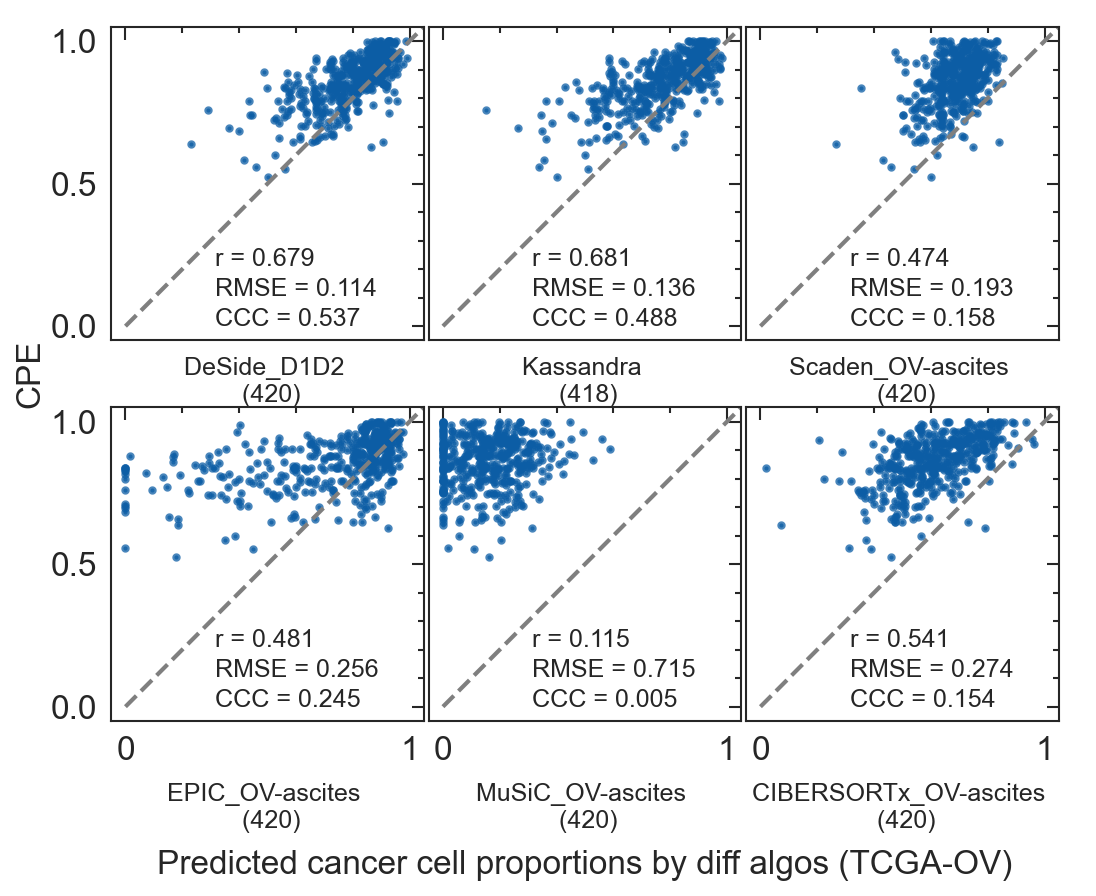

In [46]:
from deside.plot import compare_y_y_pred_plot_cpe

fig_dir = './results/reviewer2_q4/'
check_dir(fig_dir)
cols = ['DeSide_D1D2', 'Kassandra', 'Scaden_OV-ascites', 'EPIC_OV-ascites', 'MuSiC_OV-ascites',
        'CIBERSORTx_OV-ascites']
# cols_mapping = {
#     'Scaden_Scaden-simu(OV-ascites)': 'S_S_simu', 
#     'DeSide_DeSide-simu(OV-ascites)': 'D_D_simu', 
#     'DeSide_Scaden-simu(OV-ascites)': 'D_S_simu',
#     'DeSide_D1D2': 'D_D1D2',
# }
rows = ['Cancer Cells']
n_cols = 3
n_rows = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex='all', sharey='all', figsize=(4, 3.5))
metrics_value = {}
for j in range(n_cols):
    for i in range(n_rows):
        current_algo = cols[i*n_cols + j]
        current_ct = rows[0]
        if current_ct in cpe_ov.columns:
            current_data = pred_cell_frac_bulk_ov.loc[(pred_cell_frac_bulk_ov['algo'] == current_algo) & (pred_cell_frac_bulk_ov['cell_type'] == current_ct), :].copy()
            current_data['cell_prop_pred'] = current_data['cell_proportion']
            current_data.set_index('sample_id', inplace=True)
            # print('current_data', current_data)
            current_true = cpe_ov.loc[:, [current_ct]].copy()
            current_data = cpe_ov.join(current_data, how='inner')
            # print(current_data)
            # print('current_true', current_true)
            current_type = current_algo
            try:
                corr, rmse, ccc = compare_y_y_pred_plot_cpe(y_pred=current_data['cell_prop_pred'],
                                                            y_true=current_data[current_ct],
                                                            show_metrics=True, ax=axes[i, j],
                                                            cancer_type=current_type,
                                                            inx=(i, j), show_xlabel=True, show_ylabel=False)
                metrics_value[current_type] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}
            except:
                print(current_algo, current_ct)
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth_OV_tcga-4algo-metrics.csv'))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cancer cell proportions by diff algos (TCGA-OV)', labelpad=20)
plt.ylabel("CPE", labelpad=1)

plt.tight_layout(h_pad=0.02, w_pad=0.15)
plt.savefig(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth-6algo_OV_tcga.svg'), dpi=300)

## Convert the results of OV predicted by Kassandra
- these results will be used by Fig. 3

In [47]:
pred_by_kassandra_raw = pd.read_csv('../results/TCGA_predictions_for_web_kassandra/Kassandra_TCGA/OV_BG_deconvolution.tsv', index_col=0, sep='\t').T
print(pred_by_kassandra_raw.shape)
pred_by_kassandra_raw.head(2)

(428, 40)


,B_cells,B_cells_std,CD4_T_cells,CD4_T_cells_std,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_high_std,CD8_T_cells_PD1_low,CD8_T_cells_PD1_low_std,CD8_T_cells_std,...,Other,Other_std,Plasma_B_cells,Plasma_B_cells_std,T_cells,T_cells_std,T_helpers,T_helpers_std,Tregs,Tregs_std
TCGA-04-1348-01,0.008637,0.001242,0.064357,0.007102,0.093846,0.055172,0.010342,0.038674,0.006739,0.010812,...,0.727868,0.010383,0.006173,0.00090,0.158203,0.008415,0.008628,0.002639,0.055729,0.006655
TCGA-10-0926-01,0.006058,0.001848,0.002693,0.000453,0.007476,0.003911,0.000409,0.003565,0.000400,0.000675,...,0.891858,0.011005,0.001719,0.00038,0.010169,0.000897,0.001141,0.000956,0.001552,0.000828


In [48]:
pred_by_kassandra_raw.rename(index=sample_id_mappling, inplace=True)
pred_by_kassandra_raw.index.unique()

Index(['TCGA-04-1348-01A', 'TCGA-10-0926-01A', 'TCGA-61-2002-01A',
       'TCGA-61-1995-01A', 'TCGA-29-2414-02', 'TCGA-23-1030-01A',
       'TCGA-61-1914-01A', 'TCGA-25-1312-01A', 'TCGA-24-1565-01A',
       'TCGA-04-1332-01A',
       ...
       'TCGA-OY-A56Q-01A', 'TCGA-5X-AA5U-01A', 'TCGA-30-1857-01A',
       'TCGA-13-A5FT-01A', 'TCGA-OY-A56P-01A', 'TCGA-WR-A838-01A',
       'TCGA-3P-A9WA-01A', 'TCGA-29-A5NZ-01A', 'TCGA-36-1574-01A',
       'TCGA-VG-A8LO-01A'],
      dtype='object', length=428)

In [49]:
pred_by_kassandra_other_cancer_types = pd.read_csv('../tables_model_evaluation/predicted_cell_fractions/Kassandra_result/all_result_with_ov.csv', index_col=0)
pred_by_kassandra_other_cancer_types.head(2)

,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,...,NK_cells,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells
TCGA-OR-A5LO-01A,2.68,0.33,0.45,0.27,0.18,5.05,3.65,3.55,0.78,0.07,...,0.09,0.07,2.65,86.66,0.03,0.78,0.02,0.30,1.02,8.70
TCGA-P6-A5OG-01A,0.50,5.28,10.17,5.85,4.32,13.19,18.44,17.30,10.23,1.86,...,1.34,16.64,0.34,24.09,0.16,15.46,2.71,2.58,10.34,31.63


In [50]:
pred_by_kassandra_raw = pred_by_kassandra_raw.loc[:, pred_by_kassandra_raw.columns.isin(pred_by_kassandra_other_cancer_types.columns)].copy()
pred_by_kassandra_raw = pred_by_kassandra_raw * 100
print(pred_by_kassandra_raw.shape)
pred_by_kassandra_raw.head(2)

(428, 20)


,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,Macrophages_M2,Monocytes,NK_cells,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs
TCGA-04-1348-01A,0.863660,6.435704,9.384627,5.517241,3.867386,1.133269,2.826734,18.047790,4.611971,1.978415,2.633556,0.394087,1.363799,0.199313,0.246371,72.786836,0.617289,15.820331,0.862824,5.572880
TCGA-10-0926-01A,0.605774,0.269302,0.747568,0.391089,0.356479,1.254387,5.520400,1.912999,1.888199,1.502330,0.385870,0.099861,0.290354,0.138388,0.433856,89.185767,0.171918,1.016870,0.114119,0.155182


In [51]:
pred_by_kassandra = pd.concat([pred_by_kassandra_other_cancer_types, pred_by_kassandra_raw], axis=0)
pred_by_kassandra.shape

(8555, 22)

In [52]:
pred_by_kassandra_other_cancer_types.shape

(8127, 22)

In [53]:
[i for i in pred_by_kassandra_other_cancer_types.columns if i not in pred_by_kassandra_raw.columns]

['Monocytic_cells', 'Stromal_cells']

In [54]:
# pred_by_kassandra.to_csv('../tables_model_evaluation/predicted_cell_fractions/Kassandra_result/all_result_with_ov.csv', float_format='%.2f')

In [55]:
pred_epic_tref_ov = pd.read_csv('../results/TCGA_predictions_for_web_kassandra/EPIC_TCGA/OV_EPIC_TRef.tsv', index_col=0, sep='\t')
pred_epic_tref_ov.head(2)

,B_cells,Fibroblasts,CD4_T_cells,CD8_T_cells,Endothelium,Macrophages,NK_cells,Other,T_cells,Lymphocytes
TCGA-04-1348-01,0.002301,0.020240,0.014278,0.002420,0.006708,0.024759,1.384179e-03,0.927910,0.016698,0.020383
TCGA-10-0926-01,0.001191,0.035688,0.014612,0.006661,0.010400,0.005256,2.631974e-10,0.926193,0.021273,0.022464


In [56]:
pred_epic_tref_ov.rename(index=sample_id_mappling, inplace=True)
pred_epic_tref_ov.shape

(428, 10)

In [57]:
pred_epic_tref_ov.head(2)

,B_cells,Fibroblasts,CD4_T_cells,CD8_T_cells,Endothelium,Macrophages,NK_cells,Other,T_cells,Lymphocytes
TCGA-04-1348-01A,0.002301,0.020240,0.014278,0.002420,0.006708,0.024759,1.384179e-03,0.927910,0.016698,0.020383
TCGA-10-0926-01A,0.001191,0.035688,0.014612,0.006661,0.010400,0.005256,2.631974e-10,0.926193,0.021273,0.022464


In [58]:
pred_epic_tref_acc = pd.read_csv('../tables_model_evaluation/predicted_cell_fractions/EPIC_1125/EPIC_self_sig_and_ct/data/ACC.txt', index_col=0, sep='\t')
pred_epic_tref_acc.head(2)

,CD4.T,Macrophages,CD8.T,B.cells,Fibroblasts,Endothelial.Cells,NK,otherCells
TCGA.OR.A5LO.01A,0.115069,0.001473,2.670808e-02,0.005860,0.019631,0.064387,5.777482e-09,0.766872
TCGA.P6.A5OG.01A,0.007738,0.037813,6.741025e-07,0.001296,0.363108,0.213057,2.486139e-03,0.374501


In [59]:
pred_epic_tref_ov.columns.to_list(), pred_epic_tref_acc.columns.to_list()

(['B_cells',
  'Fibroblasts',
  'CD4_T_cells',
  'CD8_T_cells',
  'Endothelium',
  'Macrophages',
  'NK_cells',
  'Other',
  'T_cells',
  'Lymphocytes'],
 ['CD4.T',
  'Macrophages',
  'CD8.T',
  'B.cells',
  'Fibroblasts',
  'Endothelial.Cells',
  'NK',
  'otherCells'])

In [60]:
cell_type_name_mapping = {
  'B_cells': 'B.cells',
  'Fibroblasts': 'Fibroblasts',
  'CD4_T_cells': 'CD4.T',
  'CD8_T_cells': 'CD8.T',
  'Endothelium': 'Endothelial.Cells',
  'Macrophages': 'Macrophages',
  'NK_cells': 'NK',
  'Other': 'otherCells',
}

In [61]:
pred_epic_tref_ov.rename(columns=cell_type_name_mapping, inplace=True)
pred_epic_tref_ov = pred_epic_tref_ov.loc[:, pred_epic_tref_acc.columns].copy()
pred_epic_tref_ov.head(2)

,CD4.T,Macrophages,CD8.T,B.cells,Fibroblasts,Endothelial.Cells,NK,otherCells
TCGA-04-1348-01A,0.014278,0.024759,0.002420,0.002301,0.020240,0.006708,1.384179e-03,0.927910
TCGA-10-0926-01A,0.014612,0.005256,0.006661,0.001191,0.035688,0.010400,2.631974e-10,0.926193


In [62]:
pred_epic_tref_ov.sum(axis=1)

TCGA-04-1348-01A    1.0
TCGA-10-0926-01A    1.0
TCGA-61-2002-01A    1.0
TCGA-61-1995-01A    1.0
TCGA-29-2414-02     1.0
                   ... 
TCGA-WR-A838-01A    1.0
TCGA-3P-A9WA-01A    1.0
TCGA-29-A5NZ-01A    1.0
TCGA-36-1574-01A    1.0
TCGA-VG-A8LO-01A    1.0
Length: 428, dtype: float64

In [63]:
# pred_epic_tref_ov.to_csv('../tables_model_evaluation/predicted_cell_fractions/EPIC_1125/EPIC_self_sig_and_ct/data/OV.txt', sep='\t')